### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.convert import array_to_table
from pyrsgis.ml import imageChipsFromArray
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from statistics import mean
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

### Loading the multispectral image

In [3]:
# file names
feature_file = './BrokenHill_ASTER.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Output()), _…

### Normalizing

In [4]:
arrFeatures = array_to_table(arrFeatures)
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

# normalize the image
for i in range(arrFeatures.shape[1]):
    bandMin = arrFeatures[:, i].min()
    bandMax = arrFeatures[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[0]):
        arrFeatures_fuzzy[j, i] = (arrFeatures[j, i]-bandMin)/bandRange

### Loading the training dataset (manual)

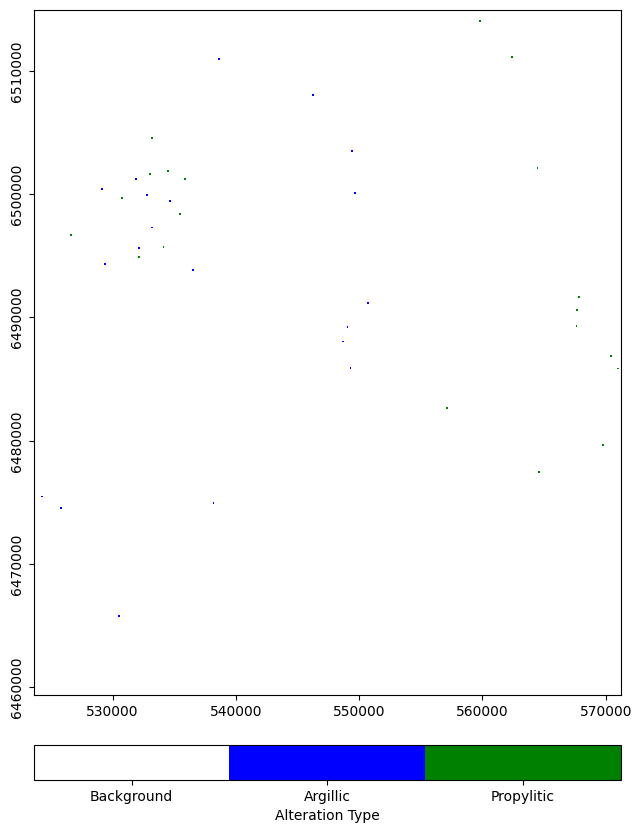

In [4]:
positiveLabel_file = './BrokenHill_ASTER_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

Epoch 1/100
134/134 [==============================] - 1s 3ms/step - loss: 0.8116 - accuracy: 0.6423 - val_loss: 0.4533 - val_accuracy: 0.8352
Epoch 2/100
134/134 [==============================] - 0s 2ms/step - loss: 0.3713 - accuracy: 0.8707 - val_loss: 0.2630 - val_accuracy: 0.9157
Epoch 3/100
134/134 [==============================] - 0s 2ms/step - loss: 0.2199 - accuracy: 0.9343 - val_loss: 0.1762 - val_accuracy: 0.9485
Epoch 4/100
134/134 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.9275 - val_loss: 0.1853 - val_accuracy: 0.9403
Epoch 5/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1652 - accuracy: 0.9421 - val_loss: 0.1418 - val_accuracy: 0.9584
Epoch 6/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1566 - accuracy: 0.9498 - val_loss: 0.1523 - val_accuracy: 0.9540
Epoch 7/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1291 - accuracy: 0.9587 - val_loss: 0.1140 - val_accuracy: 0.9693

Epoch 58/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1094 - accuracy: 0.9660 - val_loss: 0.0987 - val_accuracy: 0.9710
Epoch 59/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0863 - accuracy: 0.9742 - val_loss: 0.1442 - val_accuracy: 0.9485
Epoch 60/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1121 - accuracy: 0.9632 - val_loss: 0.2032 - val_accuracy: 0.9206
Epoch 61/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1036 - accuracy: 0.9648 - val_loss: 0.0962 - val_accuracy: 0.9710
Epoch 62/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1103 - accuracy: 0.9636 - val_loss: 0.0804 - val_accuracy: 0.9792
Epoch 63/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9690 - val_loss: 0.0792 - val_accuracy: 0.9776
Epoch 64/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0894 - accuracy: 0.9704 - val_loss: 0.1456 - val_accuracy:

Epoch 64/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1003 - accuracy: 0.9648 - val_loss: 0.1032 - val_accuracy: 0.9666
Epoch 65/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1026 - accuracy: 0.9629 - val_loss: 0.1010 - val_accuracy: 0.9704
Epoch 66/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0912 - accuracy: 0.9672 - val_loss: 0.0737 - val_accuracy: 0.9797
Epoch 67/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0885 - accuracy: 0.9707 - val_loss: 0.0976 - val_accuracy: 0.9688
Epoch 68/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0872 - accuracy: 0.9723 - val_loss: 0.0879 - val_accuracy: 0.9765
Epoch 69/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1025 - accuracy: 0.9665 - val_loss: 0.0834 - val_accuracy: 0.9770
Epoch 70/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1055 - accuracy: 0.9655 - val_loss: 0.0954 - val_accuracy:

Epoch 70/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0912 - accuracy: 0.9704 - val_loss: 0.0783 - val_accuracy: 0.9765
Epoch 71/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1001 - accuracy: 0.9665 - val_loss: 0.0819 - val_accuracy: 0.9770
Epoch 72/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9723 - val_loss: 0.0779 - val_accuracy: 0.9770
Epoch 73/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.9608 - val_loss: 0.1074 - val_accuracy: 0.9661
Epoch 74/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.9747 - val_loss: 0.0820 - val_accuracy: 0.9759
Epoch 75/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1072 - accuracy: 0.9618 - val_loss: 0.0854 - val_accuracy: 0.9770
Epoch 76/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9704 - val_loss: 0.1049 - val_accuracy:

Epoch 76/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9754 - val_loss: 0.0728 - val_accuracy: 0.9748
Epoch 77/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9674 - val_loss: 0.0751 - val_accuracy: 0.9765
Epoch 78/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0974 - accuracy: 0.9679 - val_loss: 0.3111 - val_accuracy: 0.8708
Epoch 79/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9697 - val_loss: 0.1032 - val_accuracy: 0.9655
Epoch 80/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1049 - accuracy: 0.9646 - val_loss: 0.1260 - val_accuracy: 0.9480
Epoch 81/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1182 - accuracy: 0.9643 - val_loss: 0.1671 - val_accuracy: 0.9420
Epoch 82/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1030 - accuracy: 0.9655 - val_loss: 0.0702 - val_accuracy:

Epoch 82/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0808 - accuracy: 0.9723 - val_loss: 0.0967 - val_accuracy: 0.9622
Epoch 83/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0840 - accuracy: 0.9751 - val_loss: 0.0707 - val_accuracy: 0.9776
Epoch 84/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0966 - accuracy: 0.9669 - val_loss: 0.0847 - val_accuracy: 0.9759
Epoch 85/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0859 - accuracy: 0.9714 - val_loss: 0.2174 - val_accuracy: 0.9239
Epoch 86/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1093 - accuracy: 0.9592 - val_loss: 0.0901 - val_accuracy: 0.9710
Epoch 87/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9716 - val_loss: 0.2104 - val_accuracy: 0.9343
Epoch 88/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0987 - accuracy: 0.9683 - val_loss: 0.0821 - val_accuracy:

Epoch 88/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9686 - val_loss: 0.1065 - val_accuracy: 0.9661
Epoch 89/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.9697 - val_loss: 0.0653 - val_accuracy: 0.9819
Epoch 90/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0898 - accuracy: 0.9709 - val_loss: 0.2659 - val_accuracy: 0.9031
Epoch 91/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0946 - accuracy: 0.9704 - val_loss: 0.0638 - val_accuracy: 0.9847
Epoch 92/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0854 - accuracy: 0.9735 - val_loss: 0.0779 - val_accuracy: 0.9776
Epoch 93/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0857 - accuracy: 0.9735 - val_loss: 0.0978 - val_accuracy: 0.9704
Epoch 94/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9702 - val_loss: 0.0964 - val_accuracy:

Epoch 94/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1005 - accuracy: 0.9655 - val_loss: 0.1270 - val_accuracy: 0.9568
Epoch 95/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1105 - accuracy: 0.9622 - val_loss: 0.0802 - val_accuracy: 0.9748
Epoch 96/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.9789 - val_loss: 0.0777 - val_accuracy: 0.9765
Epoch 97/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0773 - accuracy: 0.9772 - val_loss: 0.0804 - val_accuracy: 0.9776
Epoch 98/100
134/134 [==============================] - 0s 1ms/step - loss: 0.0865 - accuracy: 0.9730 - val_loss: 0.1566 - val_accuracy: 0.9381
Epoch 99/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1089 - accuracy: 0.9622 - val_loss: 0.1176 - val_accuracy: 0.9546
Epoch 100/100
58/58 [==============================] - 0s 701us/step
Epoch 1/100
134/134 [==============================] - 1s 2ms/step 

Epoch 100/100
58/58 [==============================] - 0s 702us/step
Epoch 1/100
134/134 [==============================] - 1s 2ms/step - loss: 0.9478 - accuracy: 0.5421 - val_loss: 0.6285 - val_accuracy: 0.7838
Epoch 2/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4589 - accuracy: 0.8309 - val_loss: 0.3801 - val_accuracy: 0.8621
Epoch 3/100
134/134 [==============================] - 0s 1ms/step - loss: 0.2844 - accuracy: 0.9048 - val_loss: 0.2040 - val_accuracy: 0.9321
Epoch 4/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1965 - accuracy: 0.9320 - val_loss: 0.1490 - val_accuracy: 0.9568
Epoch 5/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1736 - accuracy: 0.9369 - val_loss: 0.1584 - val_accuracy: 0.9557
Epoch 6/100
134/134 [==============================] - 0s 1ms/step - loss: 0.1502 - accuracy: 0.9500 - val_loss: 0.1372 - val_accuracy: 0.9584
Epoch 7/100
134/134 [==============================] - 0s 1ms/step - loss

58/58 [==============================] - 0s 701us/step
Epoch 1/100
134/134 [==============================] - 1s 2ms/step - loss: 0.8737 - accuracy: 0.5968 - val_loss: 0.6316 - val_accuracy: 0.7280
Epoch 2/100
134/134 [==============================] - 0s 1ms/step - loss: 0.5508 - accuracy: 0.7624 - val_loss: 0.4985 - val_accuracy: 0.7931
Epoch 3/100
134/134 [==============================] - 0s 1ms/step - loss: 0.4099 - accuracy: 0.8391 - val_loss: 0.3583 - val_accuracy: 0.8714
Epoch 4/100
134/134 [==============================] - 0s 1ms/step - loss: 0.3135 - accuracy: 0.8820 - val_loss: 0.2534 - val_accuracy: 0.9184
Epoch 5/100
134/134 [==============================] - 0s 2ms/step - loss: 0.2596 - accuracy: 0.9057 - val_loss: 0.2102 - val_accuracy: 0.9327
Epoch 6/100
134/134 [==============================] - 0s 2ms/step - loss: 0.2210 - accuracy: 0.9235 - val_loss: 0.2287 - val_accuracy: 0.9239
Epoch 7/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1948 - acc

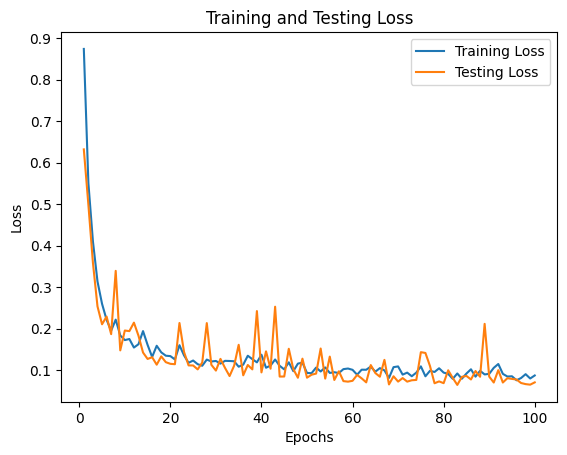

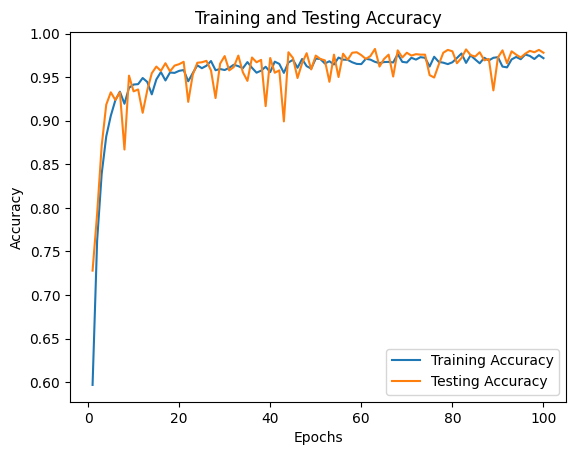

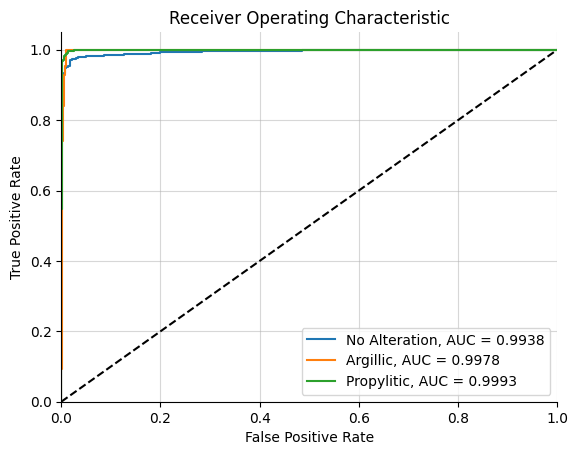

ROC AUC score: 0.9969849055686977


In [7]:
def roc_auc(model, test_x, test_y, n_classes):
    roc_auc = []
    test_z = model.predict(test_x)
    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        roc_auc.append(roc_auc_score(test_y_dummies[:, i], test_z[:, i]))
    
    return roc_auc

# plot any graph relating to any model
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Testing '+metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Training '+metric.capitalize(), 'Testing '+metric.capitalize()])
    plt.show()
    
def roc_plot(test_y, test_z, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_y_dummies = pd.get_dummies(test_y).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], test_z[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))
    
    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(test_y_dummies, test_z, average=average))

best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 10
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Propylitic', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation='selu', input_shape=(train_x.shape[1], )))
    model.add(tf.keras.layers.Dense(6, activation='selu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))
    
    for j in range(cv):
        train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)
        
        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Propylitic']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

367904/367904 [==============================] - 282s 766us/step


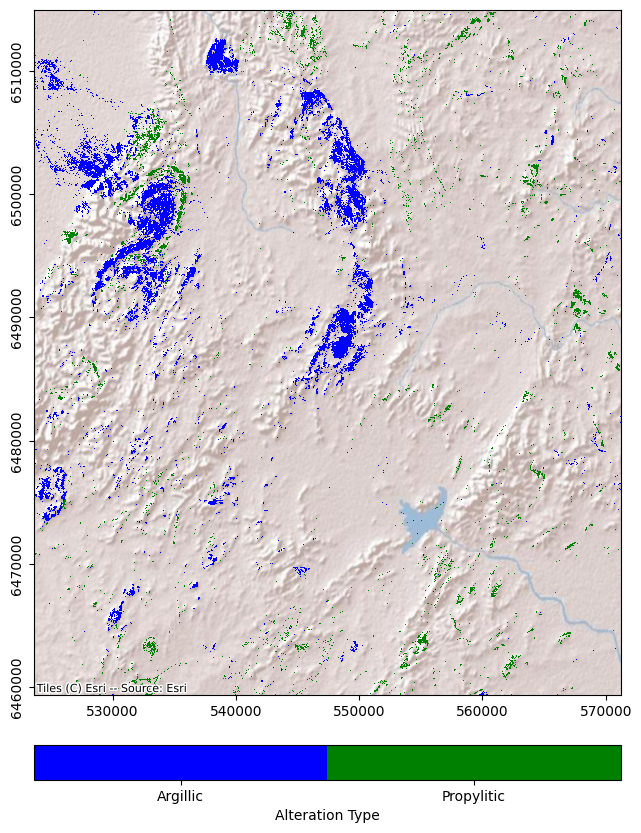

In [8]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = best_model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

outFile = './Outputs/BrokenHill_ASTER_Manual_MLP_AlterationMap.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

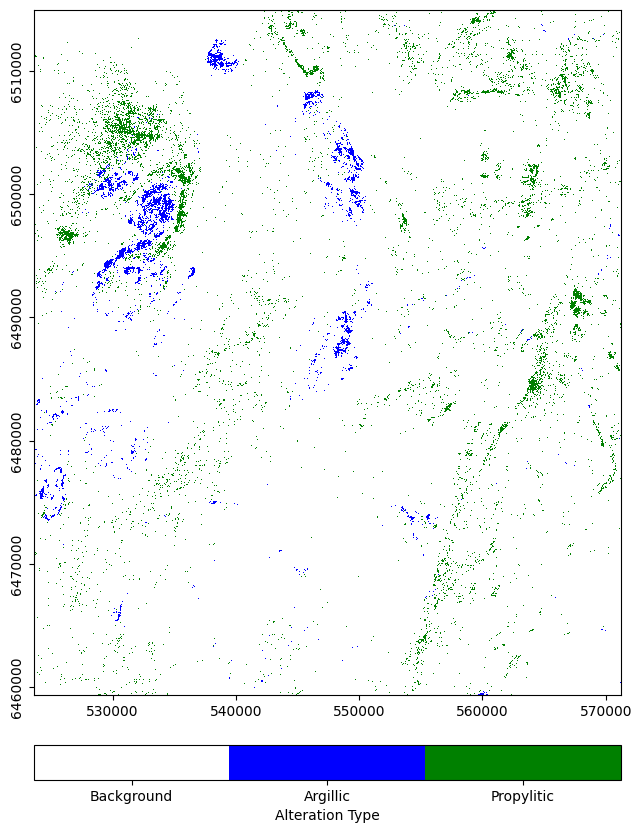

In [5]:
positiveLabel_file = './BrokenHill_ASTER_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [10]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

Epoch 1/50
12873/12873 [==============================] - 58s 4ms/step - loss: 0.1953 - accuracy: 0.9255 - val_loss: 0.1087 - val_accuracy: 0.9608
Epoch 2/50
12873/12873 [==============================] - 58s 5ms/step - loss: 0.1153 - accuracy: 0.9614 - val_loss: 0.1634 - val_accuracy: 0.9252
Epoch 3/50
12873/12873 [==============================] - 61s 5ms/step - loss: 0.1046 - accuracy: 0.9658 - val_loss: 0.0750 - val_accuracy: 0.9715
Epoch 4/50
12873/12873 [==============================] - 58s 5ms/step - loss: 0.0933 - accuracy: 0.9698 - val_loss: 0.0389 - val_accuracy: 0.9886
Epoch 5/50
12873/12873 [==============================] - 50s 4ms/step - loss: 0.0832 - accuracy: 0.9736 - val_loss: 0.0527 - val_accuracy: 0.9839
Epoch 6/50
12873/12873 [==============================] - 51s 4ms/step - loss: 0.0820 - accuracy: 0.9745 - val_loss: 0.0526 - val_accuracy: 0.9835
Epoch 7/50
12873/12873 [==============================] - 51s 4ms/step - loss: 0.0782 - accuracy: 0.9758 - val_loss: 0

5517/5517 [==============================] - 11s 2ms/step
Epoch 1/50
12873/12873 [==============================] - 51s 4ms/step - loss: 0.2151 - accuracy: 0.9139 - val_loss: 0.1268 - val_accuracy: 0.9643
Epoch 2/50
12873/12873 [==============================] - 49s 4ms/step - loss: 0.1175 - accuracy: 0.9606 - val_loss: 0.0766 - val_accuracy: 0.9711
Epoch 3/50
12873/12873 [==============================] - 50s 4ms/step - loss: 0.1010 - accuracy: 0.9666 - val_loss: 0.2079 - val_accuracy: 0.9077
Epoch 4/50
12873/12873 [==============================] - 49s 4ms/step - loss: 0.0904 - accuracy: 0.9709 - val_loss: 0.0902 - val_accuracy: 0.9689
Epoch 5/50
12873/12873 [==============================] - 48s 4ms/step - loss: 0.0864 - accuracy: 0.9723 - val_loss: 0.0551 - val_accuracy: 0.9796
Epoch 6/50
12873/12873 [==============================] - 52s 4ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.0425 - val_accuracy: 0.9843
Epoch 7/50
12873/12873 [==============================] - 57

5517/5517 [==============================] - 5s 972us/step
Epoch 1/50
12873/12873 [==============================] - 30s 2ms/step - loss: 0.2026 - accuracy: 0.9209 - val_loss: 0.2678 - val_accuracy: 0.8863
Epoch 2/50
12873/12873 [==============================] - 28s 2ms/step - loss: 0.1155 - accuracy: 0.9622 - val_loss: 0.0470 - val_accuracy: 0.9866
Epoch 3/50
12873/12873 [==============================] - 29s 2ms/step - loss: 0.1007 - accuracy: 0.9671 - val_loss: 0.1830 - val_accuracy: 0.9556
Epoch 4/50
12873/12873 [==============================] - 31s 2ms/step - loss: 0.0897 - accuracy: 0.9714 - val_loss: 0.1926 - val_accuracy: 0.8903
Epoch 5/50
12873/12873 [==============================] - 31s 2ms/step - loss: 0.0855 - accuracy: 0.9727 - val_loss: 0.0930 - val_accuracy: 0.9832
Epoch 6/50
12873/12873 [==============================] - 32s 3ms/step - loss: 0.0806 - accuracy: 0.9750 - val_loss: 0.0405 - val_accuracy: 0.9898
Epoch 7/50
12873/12873 [==============================] - 3

12873/12873 [==============================] - 26s 2ms/step - loss: 0.0418 - accuracy: 0.9885 - val_loss: 0.0342 - val_accuracy: 0.9882
Epoch 47/50
12873/12873 [==============================] - 28s 2ms/step - loss: 0.0399 - accuracy: 0.9890 - val_loss: 0.0308 - val_accuracy: 0.9896
Epoch 48/50
12873/12873 [==============================] - 26s 2ms/step - loss: 0.0414 - accuracy: 0.9885 - val_loss: 0.0284 - val_accuracy: 0.9911
Epoch 49/50
12873/12873 [==============================] - 28s 2ms/step - loss: 0.0392 - accuracy: 0.9891 - val_loss: 0.0351 - val_accuracy: 0.9891
Epoch 50/50
5517/5517 [==============================] - 5s 990us/step

Best Average Accuracy:
0.9915490803627568
5517/5517 [==============================] - 6s 1ms/step

Confusion Matrix:
[[57089   365  1126]
 [    2 32241     3]
 [    1     5 85705]]

Accuracy: 0.9914918685601318

Precision: 0.991866589592466

Recall: 0.9914408555004619

F1 Score: 0.9915747412738831


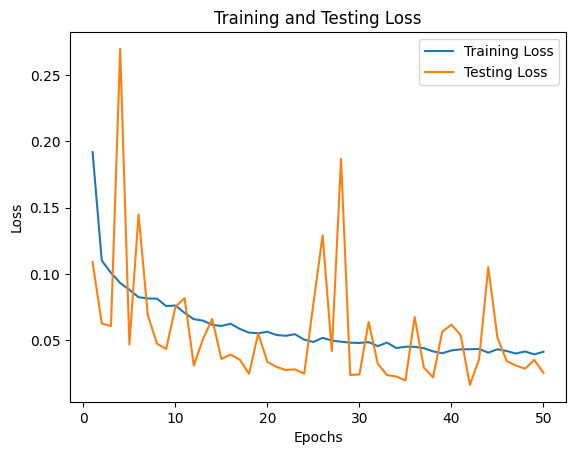

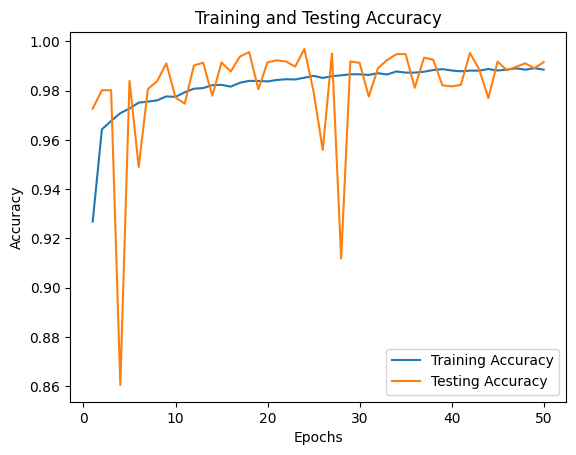

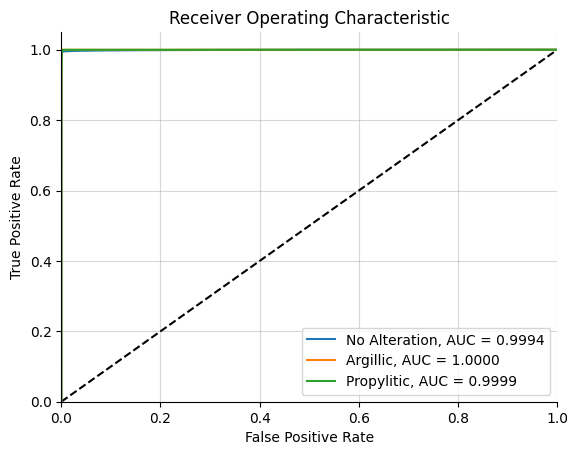

ROC AUC score: 0.999751813636491


In [11]:
best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None
experimental_runs = 5
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC_No Alteration', 'AUC_Argillic', 'AUC_Propylitic', 'AUC_Aggregate']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

for i in range(experimental_runs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation='selu', input_shape=(train_x.shape[1], )))
    model.add(tf.keras.layers.Dense(6, activation='selu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=50, validation_data=(test_x, test_y))
    
    for j in range(cv):
        train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)
        # predict for the test dataset
        test_z = model.predict(test_x)
        # calculate and display error metrics
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]
        roc_auc_class = roc_auc(model, test_x, test_y, n_class_pos)

        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()
            
            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy:\n{best_accuracy_avg}')

test_z = best_model.predict(test_x)
test_z_class = test_z.argmax(axis=1)
aScore = accuracy_score(test_y, test_z_class)
pScore = precision_score(test_y, test_z_class, average='macro')
rScore = recall_score(test_y, test_z_class, average='macro')
fScore = f1_score(test_y, test_z_class, average='macro')
cMatrix = confusion_matrix(test_y, test_z_class)
metrics_array = [aScore, pScore, rScore, fScore]
roc_auc_class = roc_auc(best_model, test_x, test_y, n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')
labels_name = ['No Alteration', 'Argillic', 'Propylitic']
roc_plot(test_y, test_z, n_class_pos, labels_name)

### Mapping alteration zones

367904/367904 [==============================] - 336s 913us/step


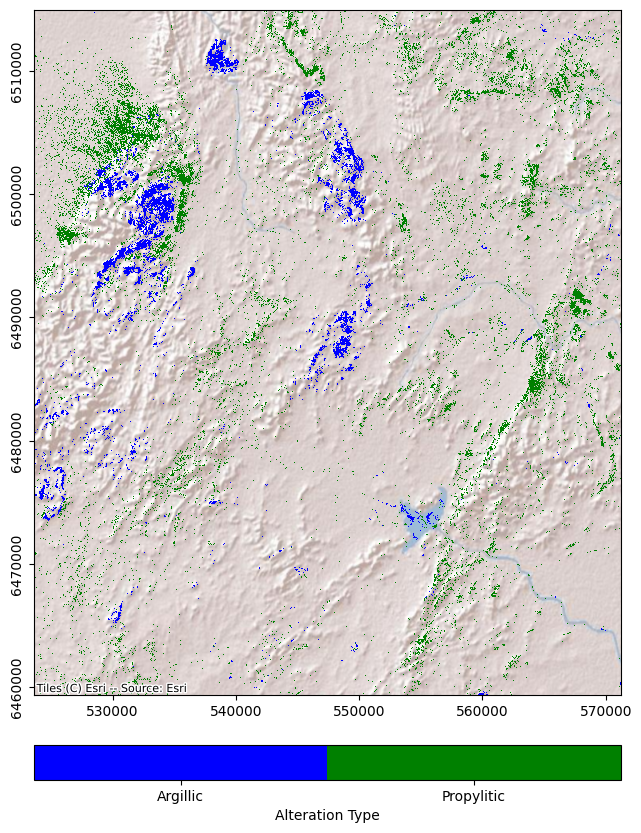

In [12]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = best_model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

outFile = './Outputs/BrokenHill_ASTER_PCA_MLP_AlterationMap.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')